# Tutorial 10 - Collective cell behaviour in confluent monolayer

Welcome to the Collective cell behaviour tutorial !
In this notebook, we'll extract structural and dynamical information at the single-cell level thanks to DDM.


### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `APPLICATION_DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686).

Your main directory tree should resemble the following:
```
.
├── APPLICATION_DATASET
│   └── ...
├── Tutorial_8-Bacterial_motion
│   └── Tutorial8a.ipynb
│   └── ...
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of Madin-Darby Canine Kidney (MDCK) cells cultured in 6-well plates (1.5 × 106 cells/well) in complete medium. Cells formed a uniform monolayer under controlled environmental conditions ( $T = 37 \mathrm{^{\circ}C}$ , $5\% ~\mathrm{CO_2}$).

The image were acquired with an Olympus IX81 microscope with an Orca-AG (Hamamatsu) CCD camera. Six randomly selected fields of view (FOVs) were imaged to minimize spatial bias. For each FOV, approximately 1400 frames (672 × 512 pixels, 2 × 2 binning) were captured at 60 s intervals over a 24-hour period, using a 10× objective resulting an effective pixel size $\delta _\mathrm{px} = 1.29 ~\mathrm{\mu m}$.

To measure the ageing effects, we will split the data into partially overlapping chunks of 200 frames, spaced by 100 frames. Then we will average the structure functions of each chunk over the different FOVs.


### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

# Config section

## analysis-level configuration

In [1]:
# flags
fit_model = "generic"  # can be 'simple', 'general' or something to be defined later
fit_dqt = False

# paths
basepath = "."  # will be expanded to absolute path
configpath = "config-fluo.toml"

## Setup functions & other things

In [2]:
from typing import Any, Optional
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings

import fastddm as fddm

from matplotlib.colors import LogNorm
from fastddm.mask import central_cross_mask
from fastddm.weights import sector_average_weight
from fastddm.utils import chunkify
from fastddm.imagestructurefunction import ImageStructureFunction
from fastddm.azimuthalaverage import AzimuthalAverage
from fastddm.lags import logspace_int

# fitting part will be imported later

## plotting inside the notebook ##

##################################

def prettyprint_config(c: dict[str, Any]) -> str:
    fmt = """=== {short_info} ===
    \rdate: {date}

    \r{info}
    
    \r:: details ::
    \rtype: {type}
    \rfps: {frame_rate}
    \rpixel size: {pixel_size} [{pixel_size_unit}]
    \rimage dimensions: {shape}
    \rfile location(s): {paths}
    
    \r:: additional config ::
    \rstart at image index: {start_at}
    """
    fip = "\rfull image paths:\n"
    fip += "\n".join([f"  - {p.as_posix()}" for p in c["full_paths"]])
    
    return fmt.format(**c) + fip

def read_config(src: str, verbose: bool = True) -> dict[str, Any]:
    import tomli
    from itertools import chain
    with open(src, "rb") as tomlfile:
        config = tomli.load(tomlfile)
    # set some defaults
    defaults = {
        "start_at": 0,
        "date": "NA",
        "frame_rate": 1.0,
        "pixel_size": 1.0,
        "pixel_size_unit": "NA",
        "info": "NA",
        "shape": "NA",
        "chunk_length": 200,
        "chunk_overlap": 100,
        "lags_extent": 0.8,
        "structural_data": None
    }
    for k, v in defaults.items():
        if k not in config:
            config[k] = v 
    
    # sanity checks & input cleaning
    if not isinstance(config["paths"], list):
        config["paths"] = [config["paths"]]
    
    # full image paths unglobbed
    config["info"] = config["info"].strip()
    full_paths = [list(Path(".").glob(p)) for p in config["paths"]]
    full_paths = list(chain(*full_paths))
    config["full_paths"] = full_paths
    
    if verbose:
        print(prettyprint_config(config))

    return config

## Other helper functions ##

def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.plasma,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))


def read_fovs(config: dict[str, Any]) -> dict[str, np.ndarray]:
    fovs = {}
    for p in config["full_paths"]:
        fovs[p.stem] = fddm.read_images(p.as_posix())[config["start_at"]:]
    
    return fovs

## reading config file, folder setup & rcParams

In [3]:
config = read_config(configpath)

=== EXP MDCK H2B GFP ===
date: 2016-06-10

MDCK cells with a seeding density of 1.5 millions. 2 repetitions, 3 FOV each
Fluo + phase contrast
    
:: details ::
type: fluo
fps: 0.0166666666666
pixel size: 1.29 [µm]
image dimensions: [512, 672]
file location(s): ['../APPLICATION_DATASET/CELL/*.tif']
    
:: additional config ::
start at image index: 0
full image paths:
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000090.tif
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000104.tif
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000088.tif
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000108.tif
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000086.tif
  - ../APPLICATION_DATASET/CELL/B755M8SH_F00000106.tif


In [4]:
# foldersetup
basepath = Path.cwd() if basepath == "." else Path(basepath).absolute()
plotpath = basepath / "plots"  # plot folders for fluo/phase created later
plotpath.mkdir(parents=True, exist_ok=True)

plotpath = plotpath / config["type"]
plotpath.mkdir(parents=True, exist_ok=True)

# setting custom rc params
rc = {
    "general": {
        # "text.usetex": True,  # latex is not yet installed!
        "savefig.dpi": 200,
        "axes.titlesize": 10
    }
}

rc["image"] = {
    "xtick.bottom": False, "ytick.left": False,
    "xtick.labelbottom": False, "ytick.labelleft": False,
    "image.cmap": "gray", "figure.figsize": (5, 4),
    "axes.titlesize": 9,
} | rc["general"]

rc["isf"] = {
    "figure.figsize": (5, 4),
    "legend.fontsize": 8
} | rc["general"]

rc["isf-fit-results"] = {
    "figure.figsize": (6, 6),
    "legend.fontsize": 6
} | rc["general"]

rc["intensity"] = {
    "figure.figsize": (4, 4),
    "legend.fontsize": 8
} | rc["general"]

rc["dqt"] = {
    "figure.figsize": (7, 5),
    "axes.titlesize": 9
} | rc["general"]

rc["Gamma"] = {
    "figure.figsize": (7, 5),
    "axes.titlesize": 9,
    "legend.fontsize": 7
} | rc["general"]

rc["pl"] = {
    "figure.figsize": (6, 4)
} | rc["general"]
###

def create_plotting_env(env: str) -> tuple[plt.Figure, plt.Axes]:
    envs = list(rc.keys())
    if env not in envs:
        raise ValueError(f"Given environment '{env}' is not in possible "
                         f"environments '{envs}'.")
    
    grids = {
        "pl": (2, 1),
        "isf-fit-results": (3, 1)
    }
    
    grid = grids.get(env, (1, 1))
    fig, ax = plt.subplots(*grid, sharex=True)
    
    if env in ["dqt", "isf"]:
        ax.set_xscale('log')
    
    if env == "dqt":
        ax.set_yscale('log')
        ax.set_ylabel(r"Image structure function $D(q,\Delta t)$")
    
    if env == "isf":
        ax.set_ylabel(r"Intermediate scattering function $f(q, \Delta t)$")
        ax.set_ylim(-0.1, 1.2)
    
    if env == "intensity":
        ax.set_ylabel("average image intensity")
        ax.set_xlabel("Age [h]")
    
    if env == "isf-fit-results":
        ax1, ax2, ax3 = ax
        # amplitude
        ax1.set_ylim(0, 1.1)
        ax1.set_xscale('log')
        ax1.set_ylabel(r"Amplitude $1-\alpha(q)$")
        
        # model exponent
        ax2.set_ylim(0, 2)
        ax2.set_ylabel(r"Model exponent $\beta$")
        
        # relaxation rate
        ax3.set_yscale('log')
        ax3.set_ylabel(r"Relaxation rate $\Gamma(q)$")
        
    if env == "Gamma":
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylabel(r"Relaxation rate $\Gamma(q)$ [1/s]")
        
    if env == "pl":
        ax1, ax2 = ax
        ax1.set_title(r"power law evolution | $\langle \Gamma(q) \rangle = v\cdot q^k$")
        ax1.set_ylabel("amplitude $v$")
        ax1.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
        ax2.set_ylim(0, 2)
        ax2.set_ylabel("exponent $k$")
        ax2.set_xlabel("(chunk) Age [h]")
        

    return fig, ax
        

def savefig(
    fig: plt.Figure, 
    name: str, 
    tight_layout: bool = True,
    pp: Optional[Path] = None
) -> None:
    
    if tight_layout:
        fig.tight_layout()
    

    
    if pp is not None:
        fig.savefig(pp / name)
    else:
        fig.savefig(plotpath / name)

# Analysis preparation

## Reading image series
and defining some quantities

In [5]:
fovs = read_fovs(config)
helper_fov = list(fovs.keys())[0]

In [6]:
# defining some quantities
fps = config["frame_rate"]
dt = config['dt'] if "dt" in config else 1/fps
age = np.arange(len(fovs[helper_fov]))*dt / 3600
pixel_size = config["pixel_size"]
shape = config["shape"]

# chunks 
movielength = len(fovs[helper_fov])
chunks = chunkify(
    np.arange(movielength), 
    config["chunk_length"], 
    overlap=config["chunk_overlap"]
)

chunklags = [
    np.arange(
        1, round(len(chunk)*config["lags_extent"], 0), dtype=np.uint16
    ) for chunk in chunks]

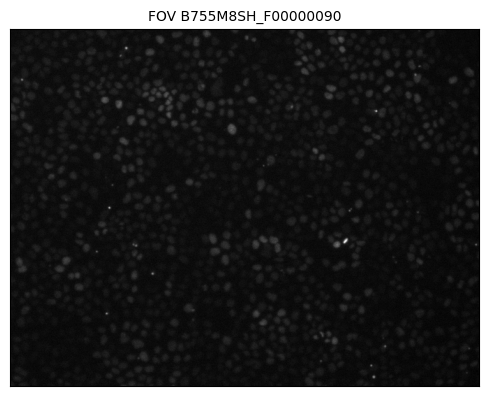

In [7]:
# %matplotlib widget
with plt.rc_context(rc=rc["image"]):
    fig, ax = create_plotting_env("image")
    ax.imshow(fovs[helper_fov][0])
    ax.set_title(f"FOV {helper_fov}")
    savefig(fig, "example-fov")

## Average Intensity

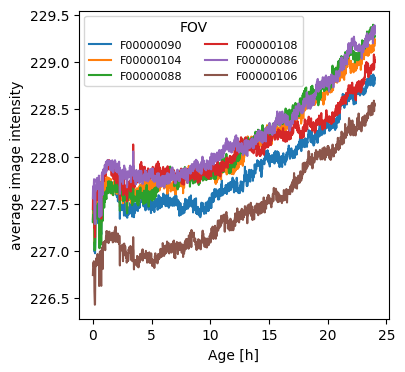

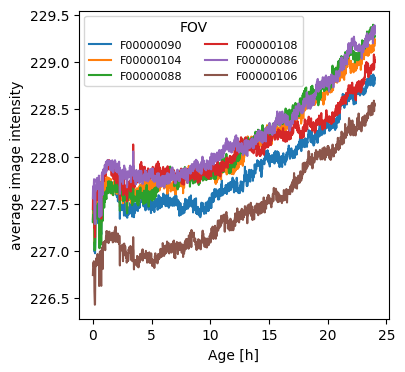

In [ ]:
with plt.rc_context(rc=rc["intensity"]):
    fig, ax = create_plotting_env("intensity")
    for fov, imgs in fovs.items():
        ax.plot(age, imgs.mean(axis=(-2, -1)), label=fov.split("_")[-1])
    ax.legend(ncol=2, title="FOV")
    plt.show()

## Performing DDM on chunks and average them directly

In [10]:
dqt = []

for i, chunk in enumerate(chunks):
    print(f":: Working on chunk {i+1}/{len(chunks)}")
    chunk_data = []
    for fov, imgs in fovs.items():
        sf = fddm.ddm(imgs[chunk], chunklags[i], core="cuda")
        sf.pixel_size = pixel_size
        sf.delta_t = dt
        chunk_data.append(sf._data)
    print(f":: Averaging chunk data now .. chunk length={len(chunk)}")
    dqt.append(
        ImageStructureFunction(
            _data=np.nanmean(chunk_data, axis=0),
            _kx=sf.kx,
            _ky=sf.ky,
            _width=sf.width,
            _height=sf.height,
            _tau=sf.tau,
            _pixel_size=pixel_size,
            _delta_t=dt
        )
    )

:: Working on chunk 1/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 2/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 3/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 4/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 5/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 6/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 7/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 8/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 9/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 10/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 11/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 12/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 13/14
:: Averaging chunk data now .. chunk length=200
:: Working on chunk 14/14
:: Averaging chunk da

## Inspect the chunk-averaged image structure function

### Raw

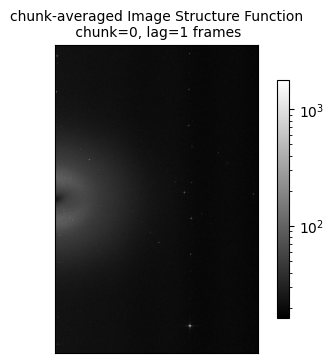

In [11]:
sample_chunk = 0
sample_lag = 0  # index/frames

with plt.rc_context(rc=rc["image"]):
    fig, ax = create_plotting_env("image")
    im = ax.imshow(dqt[sample_chunk].data[sample_lag], norm=LogNorm())
    ax.set_title(
        f"chunk-averaged Image Structure Function\n chunk={sample_chunk}, "
        f"lag={sample_lag+1} frames",
    )
    plt.colorbar(im, shrink=0.77)
    plt.show()

### and with the central cross removed

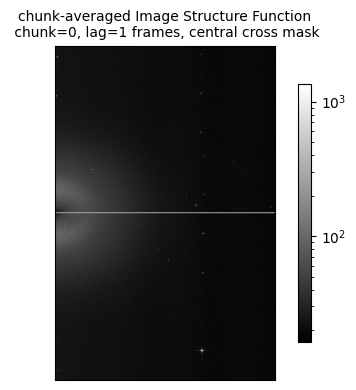

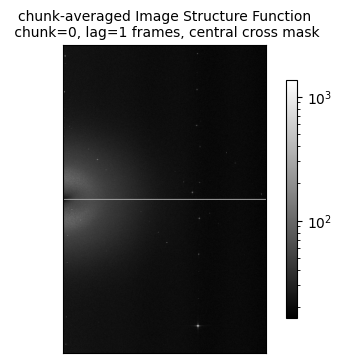

In [13]:
kx, ky = dqt[sample_chunk].kx, dqt[sample_chunk].ky
shape = dqt[sample_chunk].data.shape[1:]

ccm = central_cross_mask(shape, kx, ky)

with plt.rc_context(rc=rc["image"]):
    fig, ax = create_plotting_env("image")
    im = ax.imshow(dqt[sample_chunk].data[sample_lag]*ccm, norm=LogNorm())
    ax.set_title(
        f"chunk-averaged Image Structure Function\n chunk={sample_chunk}, "
        f"lag={sample_lag+1} frames, central cross mask",
    )
    plt.colorbar(im, shrink=0.77)
    plt.show()

## Azimuthally averaging now

In [14]:
az_avg = []
nbins = max(shape)//2  # good tradeoff between max N of bins and empty regions
ccm = central_cross_mask(dqt[0].shape[1:])

for i, sf in enumerate(dqt):
    print(f":: Working on Image structure function {i+1}/{len(dqt)}")
    az_avg.append(fddm.azimuthal_average(sf, bins=nbins, mask=ccm))

:: Working on Image structure function 1/14
:: Working on Image structure function 2/14
:: Working on Image structure function 3/14
:: Working on Image structure function 4/14
:: Working on Image structure function 5/14
:: Working on Image structure function 6/14
:: Working on Image structure function 7/14
:: Working on Image structure function 8/14
:: Working on Image structure function 9/14
:: Working on Image structure function 10/14
:: Working on Image structure function 11/14
:: Working on Image structure function 12/14
:: Working on Image structure function 13/14
:: Working on Image structure function 14/14


### cleanup, we do not need `dqt` anymore

In [15]:
del dqt

# Investigation of the azimuthally averaged Image Structure Function

## fixed chunk i.e. fixed 'age'

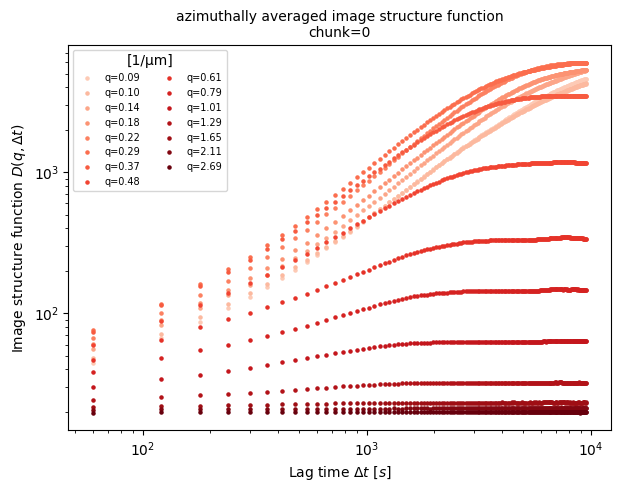

In [16]:
sample_chunk = 0
aa = az_avg[sample_chunk]
k = aa.k
tau = aa.tau

sample_k = logspace_int(len(k), num=20)[5:]  # ignore first 5 indices
cspace = color_space(len(sample_k), cm.Reds)

with plt.rc_context(rc=rc["dqt"]):
    fig, ax = create_plotting_env("dqt")

    for c, k_idx in zip(cspace, sample_k):
        ax.scatter(tau, aa.data[k_idx], color=c, s=5, 
                   label=f"q={k[k_idx]:.2f}")
    ax.legend(ncol=2, fontsize=7, title=f"[1/{config['pixel_size_unit']}]")
    ax.set_title("azimuthally averaged image structure function\n"
                 f"chunk={sample_chunk}")
    ax.set_xlabel(r"Lag time $\Delta t\ [s]$")
    plt.show()

## fixed $q$

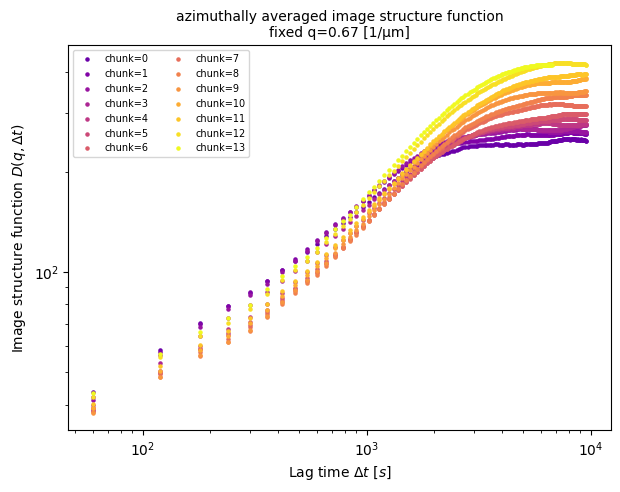

In [17]:
sample_k_idx = 50
cspace = color_space(len(az_avg))

with plt.rc_context(rc=rc["dqt"]):
    fig, ax = create_plotting_env("dqt")

    for i, aa in enumerate(az_avg):
        k = aa.k[sample_k_idx]
        tau = aa.tau
        data = aa.data[sample_k_idx]
        ax.scatter(tau, data, color=cspace[i], s=5, label=f"chunk={i}")
                
    ax.legend(ncol=2, fontsize=7)
    ax.set_title(f"azimuthally averaged image structure function\n"
                 f"fixed q={k:.2f} [1/{config['pixel_size_unit']}]")
    ax.set_xlabel(r"Lag time $\Delta t\ [s]$")
    plt.show()

## fixed lag time $\Delta t$

<>:15: SyntaxWarning: invalid escape sequence '\D'
<>:15: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2255190/512983076.py:15: SyntaxWarning: invalid escape sequence '\D'
  f"fixed $\Delta t$ = {tau:.0f} [s]")


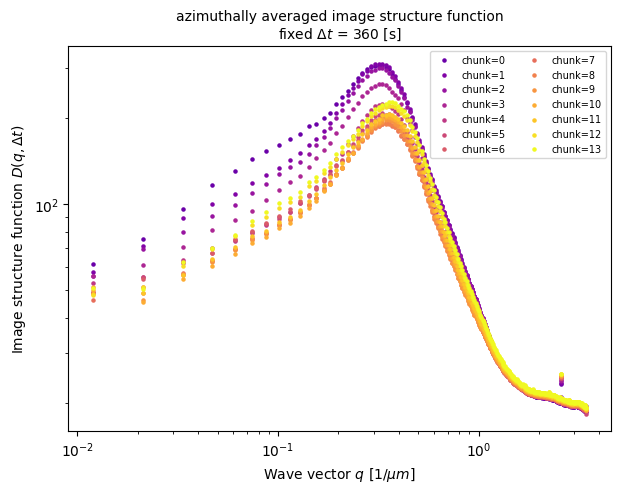

In [18]:
sample_tau_idx = 5
cspace = color_space(len(az_avg))

with plt.rc_context(rc=rc["dqt"]):
    fig, ax = create_plotting_env("dqt")

    for i, aa in enumerate(az_avg):
        k = aa.k
        tau = aa.tau[sample_tau_idx]
        data = aa.data[:, sample_tau_idx]
        ax.scatter(k, data, color=cspace[i], s=5, label=f"chunk={i}")
                
    ax.legend(ncol=2, fontsize=7)
    ax.set_title(f"azimuthally averaged image structure function\n"
                 f"fixed $\Delta t$ = {tau:.0f} [s]")
    ax.set_xlabel(r"Wave vector $q\ [1/{}]$".format(
        config['pixel_size_unit']
    ))
    plt.show()

In [19]:
import lmfit as lm
from fastddm.fit import fit_multik

exec(f"from fastddm.fit_models import {fit_model}_exponential_isf_model as isf_model")
exec(f"from fastddm.fit_models import {fit_model}_exponential_model as dqt_model")

In [20]:
dqt_model.set_param_hint("B", min=0.0)

def estimate_initial_dqt_params(aa: AzimuthalAverage) -> lm.Parameters:
    """Estimate the values for A(q), B(q), and Gamma(q)."""
    import warnings 
    from fastddm.fit import _simple_structure_function_parameter_helper
    
    estimates = []
    for i in range(len(aa.data)):  # iterate over all k
        try:
            params = _simple_structure_function_parameter_helper(aa.tau, aa.data[i])
            params.add("Gamma", min=0.0, max=np.inf, value=1/params["tau"])  # store gamma
            del params["tau"]  # cleanup of tau
            
        except Exception as e:
            warnings.warn(f"Something went wrong in estimating parameters for k index {i}: '{e}'")
            params = lm.Parameters()
            for name in ["A", "B", "Gamma"]:
                params.add(name, min=0.0, max=np.inf, value=np.nan)  # add default values
            
        estimates.append(params)
    
    return estimates

def estimates_as_array(est: list[lm.Parameters]) -> np.ndarray:
    """Convert a list of parameter estimates to a numpy array."""
    estimates = np.zeros((3, len(est)))
    for i, pars in enumerate(est):
        estimates[0][i] = pars["A"].value
        estimates[1][i] = pars["B"].value
        estimates[2][i] = pars["Gamma"].value
    
    return estimates

## estimate A, B and Gamma for all chunks


In [21]:
## estimate A, B and Gamma for all chunks

initial_estimates = [estimate_initial_dqt_params(aa) for aa in az_avg]
initial_estimates_arr = [estimates_as_array(est) for est in initial_estimates]

# Fitting the Intermediate Scattering Function (ISF)

Now, we are going to fit the intermediate scattering function (ISF) $( f(q, \Delta t) )$ to our measured image structure function $( d(q, \Delta t) )$. The derivation begins by considering that there might be a faster dynamic process not fully captured in the measurements. Thus, the "true" structure function is modeled as

$$
d(q, \Delta t) = A(q)\left[ 1-\alpha(q)f_1(q, \Delta t) - (1-\alpha(q))f_2(q, \Delta t)\right] + B(q),
$$

where each relaxation process is given by an exponential decay of the form

$$
f_i(q, \Delta t) = \exp \left[-\left(\Gamma_i \Delta t\right)^{\beta_i}\right].
$$

Here, $\Gamma_1$ and $\Gamma_2$ are the decay rates, with $\Gamma_2 \ll \Gamma_1$. This inequality indicates that the process associated with $ f_1 $ decays much faster and is effectively “invisible” in our measurements, meaning that its contribution is often neglected for the timescales of interest.

By dropping the fast decaying process $( f_1 )$, the model simplifies to

$$
d(q, \Delta t) = A(q)\left[1-(1-\alpha(q))f_2(q, \Delta t)\right] + B(q).
$$

This gives us the effective ISF as

$$
\text{ISF} = (1-\alpha(q))\exp\left[-\left(\Gamma_2 \Delta t\right)^{\beta_2}\right],
$$
which is the functional form we will ultimately use for fitting the data.

**Additional Note:**
- The code also **resamples the azimuthal average of the image structure function with logarithmically spaced $(\Delta t)$ values.** This resampling is important because it smooths out the ISF, making the fitting procedure more robust by evenly sampling the wide range of time scales in logarithmic space.

In [22]:
dqt_results_weights = []
dqt_results_use_err = []
ref = config["fit_ref_index"] # 30  # what is a good choice here???

if fit_dqt:
    
    for i, aa in enumerate(az_avg):
        print(f":: Working on chunk {i+1}/{len(az_avg)}")
        # using the weights for fitting
        dqt_results_weights.append(
            fit_multik(
                data=aa, 
                model=dqt_model, 
                ref=ref, 
                ref_params=initial_estimates[i][ref],
                weights=1/np.sqrt(aa.tau),
            )[0]  # second return value is None in our case
        )
        
        # using the err for fitting
        dqt_results_use_err.append(
        fit_multik(
            data=aa, 
            model=dqt_model, 
            ref=ref, 
            ref_params=initial_estimates[i][ref],
            use_err=True,
        )[0]  # second return value is None in our case
    )

### Average model exponent over time

In [25]:
# helper function
def get_k_limits(aa: AzimuthalAverage, lower_frac: float = 0.33, upper_frac: float = 0.07) -> int:
    """Get the index of aa.k that is closest to the point of 1/`divide_by` of the logspace k range
    for the lower limit, and closest to 90% of the length of logspace k for the upper limit.
    """
    _start = 0 if aa.k[0] != 0.0 else 1
    logspace = np.logspace(*np.log10(aa.k[[_start, -1]]), num=len(aa.k))
    lo_idx = np.argmin(np.abs(aa.k - logspace[round(len(logspace)*lower_frac)]))
    hi_idx = np.argmin(np.abs(aa.k - logspace[len(logspace) - round(len(logspace)*upper_frac)]))
    
    return lo_idx, hi_idx

# Fitting the ISF $f(q, \Delta t)$

assuming the existence of a faster process that is not captured probably, where the actual image structure function would be 
$$
D(q, \Delta t) = A(q)\left[ 1-\alpha(q)f_1(q, \Delta) - (1-\alpha(q))f_2(q, \Delta t)\right] + B(q)
$$
where $f_i(q, \Delta t) = \exp \left(-(\Gamma_i \Delta t)^{\beta_i}\right)$ and $\Gamma_2 \ll \Gamma_1$. (see google doc notes on a more detailed derivation.)

The functional shape we want to use at the end of the day is the following: 
$$
    D(q, \Delta t) = A(q)\left[1-(1-\alpha(q))f_2(q, \Delta t)\right] + B(q)
$$

giving our ISF the form $(1-\alpha(q))\exp\left[-(\Gamma_2 \Delta t)^{\beta_2}\right]$

**Note that we also resample the azimuthal average of the image structure function with logspaced $\Delta t$ values.**

In [26]:
def slow_isf(x, Gamma, alpha, beta):
    
    return (1-alpha) * np.exp(-(Gamma * x)**beta)

isf_model = lm.Model(slow_isf)
isf_model.set_param_hint("beta", min=0, value=1, max=3)
isf_model.set_param_hint("alpha", min=-0.05, value=0.0, max=1)
isf_model.set_param_hint("Gamma", min=0, value=1e-3)
isf_model.print_param_hints()

Name      Value      Min      Max     Vary    Expr    
Gamma     0.001        0      inf     True    
alpha         0    -0.05        1     True    
beta          1        0        3     True    


## Estimation of A(q) and B(q)
We also revert back to the 'old' way of estimating $A(q)$ and $B(q)$ since the curve we initially estimated for $B(q)$ doesn't seem to fit the imaging technique so well. So we will use again the method of estimating $B(q)$ via 
$$
    \lim_{q\rightarrow q_{max}} 2\langle \lvert \hat{I}(q,t)\rvert^2\rangle_t \equiv B(q) \simeq const. 
$$
which we will calculate for each chunk separately. Then, $A(q)$ can be calculated from
$$
    A(q) + B = 2\langle \lvert \hat{I}(q,t)\rvert^2\rangle_t
$$

In [27]:
def compute_isf(az_avg: list[AzimuthalAverage], resample_num: int = 50):
    isf = []
    A = []
    # B = [init[1][:] for init in initial_estimates_arr]  # estimation via polyfit
    B = []
    
    for i in range(len(az_avg)):
        aa = az_avg[i]
        # note the factors of 2 
        B.append(2*aa.power_spec[-10:].mean()*np.ones_like(aa.k))  # creating a constant array of B values
        # estimate the noise not at the outer corners of the image but at the edges
        # image_edge = np.argmin(np.abs(k - np.pi/config['pixel_size']))
        # B.append(2*aa.power_spec[image_edge-10: image_edge].mean()*np.ones_like(aa.k))
        
        _aa = aa.resample(np.logspace(*np.log10(aa.tau[[0, -1]]), num=resample_num))
        
        A.append(2*_aa.power_spec - B[i])
        
        isf_data = 1 - ((_aa._data.T - B[i])/(A[i])).T
        isf_err = (_aa._err.T / np.abs(A[i])).T
        
        isf.append(
            AzimuthalAverage(
                isf_data,
                isf_err,
                _aa.k.copy(),
                _aa.tau.copy(),
                _aa.bin_edges.copy()
            )
        )

    return isf, A, B

isf, isf_A, isf_B = compute_isf(az_avg)

In [28]:
cspace = color_space(len(chunks))

with plt.rc_context(rc=rc["dqt"] | {"figure.figsize": (4, 3)}):
    fig, ax = create_plotting_env("dqt")
    
    for i in range(len(chunks)):
        ax.plot(az_avg[i].k, isf_A[i], c=cspace[i], lw=0.7, label=i+1)
        ax.plot(az_avg[i].k, isf_B[i], c=cspace[i], ls=":", lw=0.7)
    
    ax.legend(ncol=4, title="chunks", fontsize=6, title_fontsize=7)
    ax.set_ylabel(r"$A(q),\ B(q)\ [a.u.]$")
    ax.set_xlabel(r"$q\ [1/{}]$".format(config['pixel_size_unit']))
    ax.set_title(r"Estimated $A(q)$ (solid), $B(q)$ (dotted) per chunk")
    savefig(fig, "example-isf-AandB")
    

## plot example ISF after removing $A(q)$ and $B(q)$

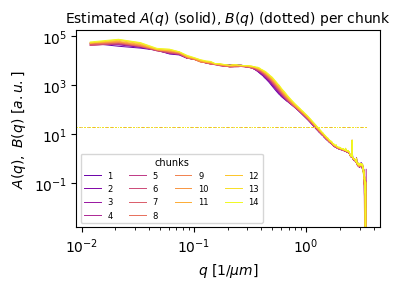

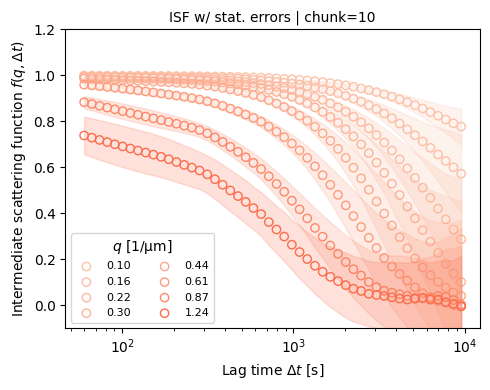

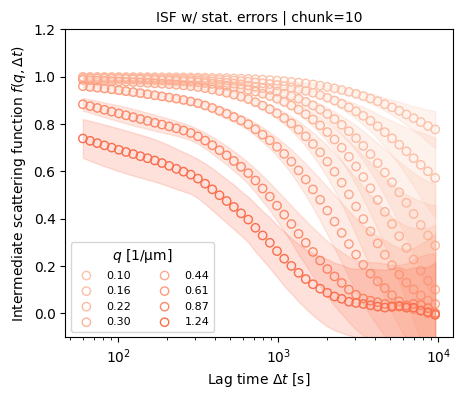

In [31]:

sample_chunk = 10

sample_k = logspace_int(len(isf[sample_chunk].k), num=15)[5:-2]
cspace = color_space(len(az_avg[sample_chunk].k), cm.Reds)

with plt.rc_context(rc=rc["isf"]):
    fig, ax = create_plotting_env("isf")

    for i in sample_k:
        ax.scatter(isf[sample_chunk].tau, isf[sample_chunk].data[i], 
                   edgecolor=cspace[i], facecolor="None", marker="o", 
                   label=f"{az_avg[sample_chunk].k[i]:.2f}"
        )
        ax.fill_between(isf[sample_chunk].tau,  # x
                        isf[sample_chunk].data[i] - isf[sample_chunk].err[i],
                        isf[sample_chunk].data[i] + isf[sample_chunk].err[i],
                        color=cspace[i], alpha=0.2
                       )
                        
        
        
    ax.legend(ncol=2, title=r"$q$ [1/{}]".format(config["pixel_size_unit"]))
    ax.set_xlabel(r"Lag time $\Delta t$ [s]")
    ax.set_title(f"ISF w/ stat. errors | chunk={sample_chunk}")
    plt.show()
    

## Fitting the ISF

In [30]:
isf_results = []
ref = config["fit_ref_index"]  #30  # what is a good choice here???

for i, aa in enumerate(isf):
    print(f":: Working on chunk {i+1}/{len(isf)}")
    # using the weights for fitting
    isf_results.append(
        fit_multik(
            data=aa, 
            model=isf_model, 
            ref=ref, 
            use_err=True,
            # nan_policy="omit"
        )[0]  # second return value is None in our case
    )

:: Working on chunk 1/14
:: Working on chunk 2/14
:: Working on chunk 3/14
:: Working on chunk 4/14
:: Working on chunk 5/14
:: Working on chunk 6/14
:: Working on chunk 7/14
:: Working on chunk 8/14
:: Working on chunk 9/14
:: Working on chunk 10/14
:: Working on chunk 11/14
:: Working on chunk 12/14
:: Working on chunk 13/14
:: Working on chunk 14/14


### example ISF w/ stat. error and q-dependant model exponent

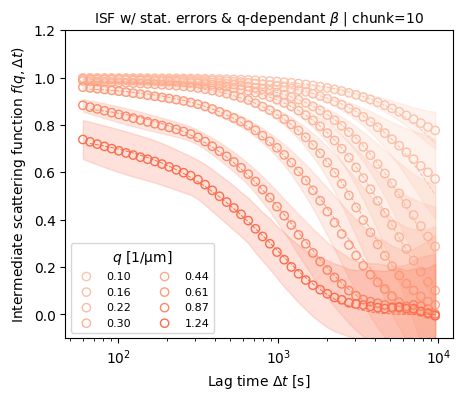

In [33]:
sample_chunk = 10


sample_k = logspace_int(len(isf[sample_chunk].k), num=15)[5:-2]
cspace = color_space(len(az_avg[sample_chunk].k), cm.Reds)
eval_tau = np.logspace(*np.log10(isf[sample_chunk].tau[[1, -1]]), num=100)

with plt.rc_context(rc=rc["isf"]):
    fig, ax = create_plotting_env("isf")

    for i in sample_k:
        ax.scatter(isf[sample_chunk].tau, isf[sample_chunk].data[i], 
                   edgecolor=cspace[i], facecolor="None", marker="o", 
                   label=f"{az_avg[sample_chunk].k[i]:.2f}"
        )
        ax.fill_between(isf[sample_chunk].tau,  # x
                        isf[sample_chunk].data[i] - isf[sample_chunk].err[i],
                        isf[sample_chunk].data[i] + isf[sample_chunk].err[i],
                        color=cspace[i], alpha=0.2
                       )
        ax.plot(eval_tau,
                isf_model.eval(
                    x=eval_tau, 
                    **{par: isf_results[sample_chunk][par][i] for par in isf_model.param_names}
                ),
                color=cspace[i],
                ls="--", lw=0.7
               )
                        
        
        
    ax.legend(ncol=2, title=r"$q$ [1/{}]".format(config["pixel_size_unit"]))
    ax.set_xlabel(r"Lag time $\Delta t$ [s]")
    ax.set_title(f"ISF w/ stat. errors & q-dependant $\\beta$ | chunk={sample_chunk}")
    plt.show()    

### Plotting the fit results per chunk

#### helper functions

In [34]:
import pandas as pd

def mean_relaxation_time(tau: np.ndarray, delta: np.ndarray):
    from scipy.special import gamma
    
    return tau/delta * gamma(1/delta)


def plot_isf_chunk_results(
    ax: plt.Axes, 
    isf_results: list[pd.DataFrame], 
    y: str, 
    cmap: cm.colors.LinearSegmentedColormap = cm.viridis
) -> plt.Axes:
    nchunks = len(isf_results)
    cspace = color_space(nchunks, cmap)
        
    for i in range(nchunks):
        res = 1-isf_results[i][y] if y == "alpha" else isf_results[i][y]
        ax.plot(
            isf_results[i]["k"],
            res,
            color=cspace[i],
            label=f"{i}"
        )
    
    return ax

def plot_isf_hlines(
    ax: plt.Axes,
    isf_result: pd.DataFrame,
    y: float = 1.0
) -> plt.Axes:
    
    ax.hlines(y, isf_result["k"].iloc[0], isf_result["k"].iloc[-1], 
              ls="--", lw=0.5, color="k")
    return ax
    


#### plot

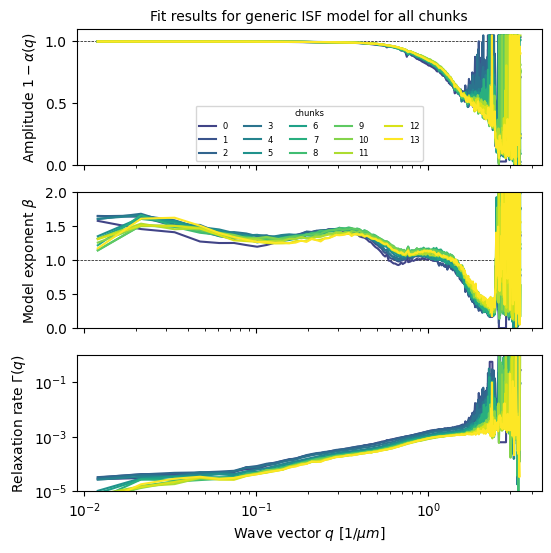

In [35]:

with plt.rc_context(rc=rc["isf-fit-results"]):
    fig, axes = create_plotting_env("isf-fit-results")
    
    # Amplitude
    ax = axes[0]
    ax.set_title(f"Fit results for {fit_model} ISF model for all chunks")
    
    ax = plot_isf_hlines(ax, isf_results[0], 1)
    ax = plot_isf_chunk_results(ax, isf_results, "alpha")
    
    ax.legend(ncol=5, title="chunks", title_fontsize=6, loc="lower center")
    
    # beta
    ax = axes[1]

    ax = plot_isf_hlines(ax, isf_results[0], 1)
    ax = plot_isf_chunk_results(ax, isf_results, "beta")
    
    #Gamma
    ax = axes[2]
    ax = plot_isf_chunk_results(ax, isf_results, "Gamma")
    ax.set_ylim(1e-5, 1e0)

    ax.set_xlabel(r"Wave vector $q\ [1/{}]$".format(config['pixel_size_unit']))
    
    plt.show()

### average model exponent over time

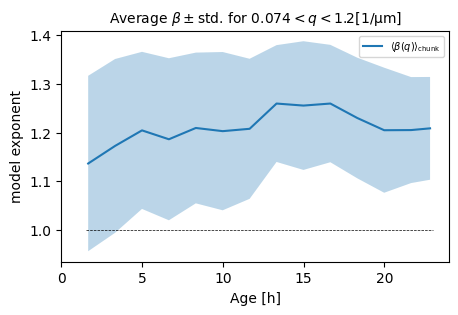

In [36]:
# reload config
config = read_config(configpath, verbose=False)

if "k_limits" in config.keys():
    lower_k_limit, upper_k_limit = get_k_limits(az_avg[0], **config['k_limits'])
else:
    lower_k_limit, upper_k_limit = get_k_limits(az_avg[0], upper_frac=0.2)

avg_beta_isf = np.array([
    (isf_chunk["beta"][lower_k_limit:upper_k_limit].mean(), isf_chunk["beta"][lower_k_limit:upper_k_limit].std()) for isf_chunk in isf_results
]).T

dt = config['dt'] if "dt" in config else 1/fps
chunk_age = np.array([(c[0]+c[-1])/2*dt/3600 for c in chunks])

with plt.rc_context(rc=rc["general"] | {"figure.figsize": (5, 3)}):
    fig, ax = create_plotting_env("intensity")
    ax.set_ylabel("model exponent")
    
    ax.plot(chunk_age, avg_beta_isf[0], label=r"$\langle \beta(q) \rangle_{\mathrm{chunk}}$")
    
    ax.fill_between(chunk_age, avg_beta_isf[0]-avg_beta_isf[1], avg_beta_isf[0]+avg_beta_isf[1],
                   alpha=0.3)
    
    ax.hlines(1, 1.5, 23, linestyle="--", linewidth=0.5, color="k")
    ax.set_title(r"Average $\beta \pm$std. for ${:.2g}<q<{:.2g}$[1/{}]".format(
        az_avg[0].k[lower_k_limit], 
        az_avg[0].k[upper_k_limit],
        config["pixel_size_unit"]))
    ax.set_xlim(0, 24)
    ax.legend(fontsize=7)
plt.show()

### re-doing the fits and fixing the model parameter for each chunk

In [37]:
isf_results_fixed = []
ref = config["fit_ref_index"]  # 30  # what is a good choice here???

for i, aa in enumerate(isf):
    print(f":: Working on chunk {i+1}/{len(isf)}, fixing beta to {avg_beta_isf[0][i]:.2f}")
    # using the weights for fitting
    isf_results_fixed.append(
        fit_multik(
            data=aa, 
            model=isf_model, 
            ref=ref, 
            # ref_params=initial_estimates[i][ref],
            fixed_params={"beta": np.full(len(aa.k), avg_beta_isf[0][i])},
            use_err=True,
            nan_policy="omit"
        )[0]  # second return value is None in our case
    )

:: Working on chunk 1/14, fixing beta to 1.14
:: Working on chunk 2/14, fixing beta to 1.17
:: Working on chunk 3/14, fixing beta to 1.20
:: Working on chunk 4/14, fixing beta to 1.19
:: Working on chunk 5/14, fixing beta to 1.21
:: Working on chunk 6/14, fixing beta to 1.20
:: Working on chunk 7/14, fixing beta to 1.21
:: Working on chunk 8/14, fixing beta to 1.26
:: Working on chunk 9/14, fixing beta to 1.26
:: Working on chunk 10/14, fixing beta to 1.26
:: Working on chunk 11/14, fixing beta to 1.23
:: Working on chunk 12/14, fixing beta to 1.21
:: Working on chunk 13/14, fixing beta to 1.21
:: Working on chunk 14/14, fixing beta to 1.21


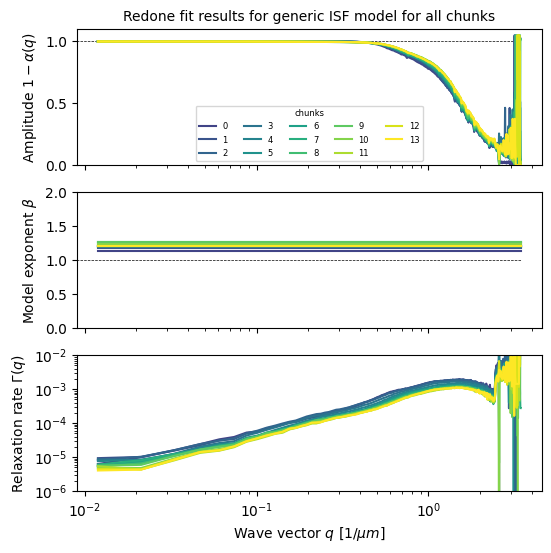

In [38]:

with plt.rc_context(rc=rc["isf-fit-results"]):
    fig, axes = create_plotting_env("isf-fit-results")
    
    # Amplitude
    ax = axes[0]
    ax.set_title(f"Redone fit results for {fit_model} ISF model for all chunks")
    
    ax = plot_isf_hlines(ax, isf_results_fixed[0], 1)
    ax = plot_isf_chunk_results(ax, isf_results_fixed, "alpha")
    
    ax.legend(ncol=5, title="chunks", title_fontsize=6, loc="lower center")
    
    # beta
    ax = axes[1]

    ax = plot_isf_hlines(ax, isf_results_fixed[0], 1)
    ax = plot_isf_chunk_results(ax, isf_results_fixed, "beta")
    
    #Gamma
    ax = axes[2]
    ax = plot_isf_chunk_results(ax, isf_results_fixed, "Gamma")
    ax.set_ylim(1e-6, 1e-2)

    ax.set_xlabel(r"Wave vector $q\ [1/{}]$".format(config['pixel_size_unit']))
    
plt.show()

### ISF with fit overlay


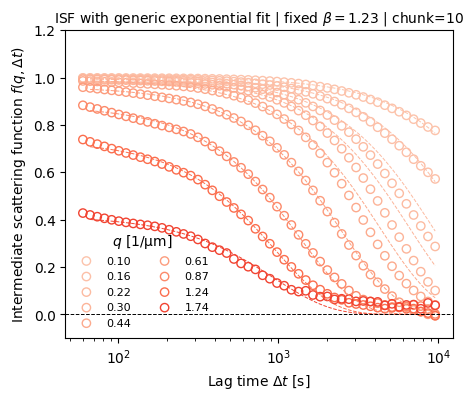

In [40]:
sample_chunk = 10

sample_k = logspace_int(len(isf[sample_chunk].k), num=15)[5:-1]
eval_tau = np.logspace(*np.log10(isf[sample_chunk].tau[[1, -1]]), num=100)
cspace = color_space(len(az_avg[sample_chunk].k), cm.Reds)

with plt.rc_context(rc=rc["isf"]):
    fig, ax = create_plotting_env("isf")

    for i in sample_k:
        ax.scatter(isf[sample_chunk].tau, isf[sample_chunk].data[i], 
                   edgecolor=cspace[i], facecolor="None", marker="o", 
                   label=f"{az_avg[sample_chunk].k[i]:.2f}"
        )
        ax.plot(eval_tau,
                isf_model.eval(
                    x=eval_tau, 
                    **{par: isf_results_fixed[sample_chunk][par][i] for par in isf_model.param_names}
                ),
                color=cspace[i],
                ls="--", lw=0.7
               )

    ax.axhline(0, ls="--", lw=0.7, color="k")
                        
    ax.legend(ncol=2, title=r"$q$ [1/{}]".format(config["pixel_size_unit"]), frameon=False)
    ax.set_xlabel(r"Lag time $\Delta t$ [s]")
    ax.set_title(
        f"ISF with {fit_model} exponential fit | fixed " \
        + r"$\beta={:.2f}$".format(avg_beta_isf[0][sample_chunk]) \
        + f" | chunk={sample_chunk}"
    )
    plt.show()    

### MSD

In [41]:
crossings = [0.29, 0.48, 0.68, 0.89, 1.12]

So now, for these values of $q$ we want to get a first estimate of the MSD by simply inverting the ISF, assuming the form:

$$
    f(\mathbf{q}, \Delta t) = \exp \left[ - \frac{q^2 \langle \lvert \Delta \mathbf{x}\rvert^2 \rangle}{4} \right]
$$
i.e.
$$
    \langle \lvert \Delta \mathbf{x}\rvert^2 \rangle = - \frac{4 \log f(\mathbf{q}, \Delta t)}{\mathbf{q}^2}
$$

and then we want to take the sequence $(q_i,\ \langle \lvert \Delta \mathbf{x}\rvert^2 \rangle_i)$ and extrapolate it to $q=0$ for all values of $\Delta t$. This value we will take to be our single cell mean square displacement. 

In [42]:
def msd_from_isf(isf: fddm.azimuthalaverage.AzimuthalAverage) -> np.ndarray:
    """Inverts the intermediate scattering function to extract an estimate of the MSD."""

    return (-4 * np.log(isf.data).T / isf.k**2).T

In [43]:
msd = msd_from_isf(isf[0])

/tmp/ipykernel_2255190/4028674309.py:4: RuntimeWarning: invalid value encountered in log
  return (-4 * np.log(isf.data).T / isf.k**2).T


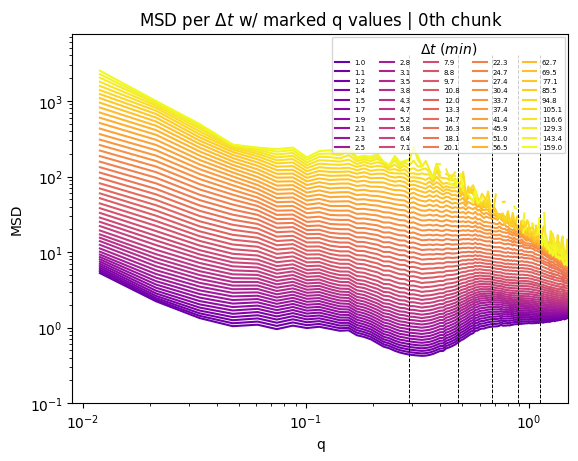

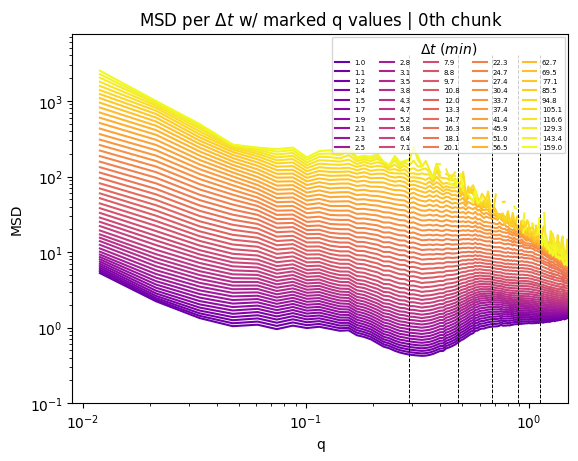

In [47]:
tau = isf[0].tau/60

time_space = color_space(len(isf[0].tau))

plt.figure()

for i, dt in enumerate(tau):
    plt.plot(k, msd[:, i], color=time_space[i], label=f"{dt:.1f}")

plt.vlines(crossings, 0.1, 4e3, ls="--", lw=0.7, color="k")

plt.yscale('log')
plt.xscale('log')
plt.xlim(None, 1.5)
plt.ylim(0.1, None)
plt.title(r"MSD per $\Delta t$ w/ marked q values | 0th chunk")
plt.xlabel('q')
plt.ylabel("MSD")
plt.legend(title=r"$\Delta t\ (min)$", ncol=5, fontsize=5)
plt.show()


we now want to investigate the sequence $(q_i,\ \langle \lvert \Delta \mathbf{x}\rvert^2 \rangle_i)$. We might also interpolate the values of the MSD so we can get some precise values for the crossings.

In [48]:
from scipy.interpolate import interp1d

msd_at_crossing = []
tau = isf[0].tau/60


for i, dt in enumerate(tau):
    msd_inter_dt = interp1d(k, msd[:, i])
    msd_at_crossing.append(msd_inter_dt(np.array(crossings)))

msd_at_crossing = np.array(msd_at_crossing)

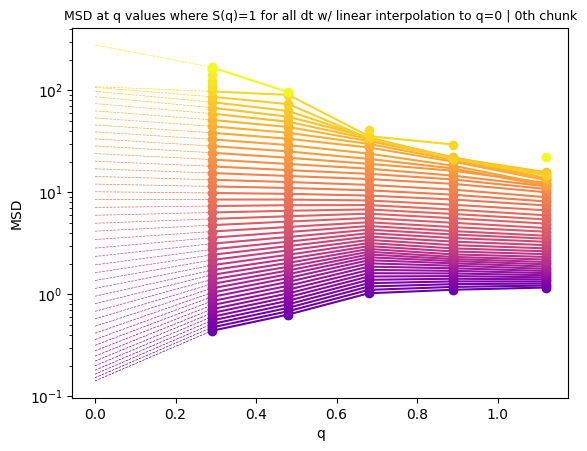

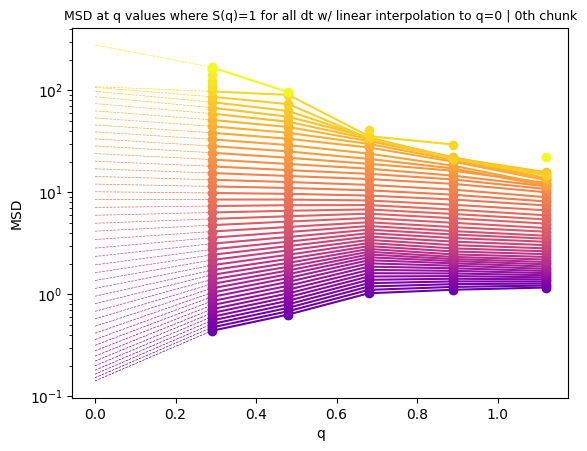

In [50]:
plt.figure()

single_cell_msd = []

for i, dt in enumerate(tau):
    _inter_msd = interp1d(crossings, msd_at_crossing[i], fill_value="extrapolate")
    plt.plot(crossings, msd_at_crossing[i], "o-", color=time_space[i])
    plt.plot([0] + crossings, _inter_msd(np.array([0] + crossings)), ls="--", lw=0.5, color=time_space[i])
    single_cell_msd.append(_inter_msd(0))
plt.yscale('log')
plt.title("MSD at q values where S(q)=1 for all dt w/ linear interpolation to q=0 | 0th chunk", fontsize=9)
plt.xlabel('q')
plt.ylabel("MSD")
plt.show()

The values extrapolated to 0 are now our "real" single cell MSD, which we can fit further with
$$
    \langle \lvert \Delta \mathbf{x}\rvert^2 \rangle = \Delta x_0^2 + D_{eff} \Delta t^\beta
$$

In [51]:
def msd_fit(dt, x0_2, Deff, beta): 
    return x0_2 + Deff * dt**beta

msd_model = lm.Model(msd_fit)
msd_model.set_param_hint("beta", min=0, value=1.5, vary=True)
msd_model.set_param_hint("Deff", min=0, value=5e-4)
msd_model.set_param_hint("x0_2", min=0, value=1e-2)

ignore_first = 23
ignore_last = 8
fit_dt = isf[0].tau[ignore_first:-ignore_last]

result = msd_model.fit(
    np.array(single_cell_msd)[ignore_first:-ignore_last], 
    dt=fit_dt
)

result.best_values

{'x0_2': 1.9872992140790302e-13,
 'Deff': 0.00017969113725979646,
 'beta': 1.5705845188885768}

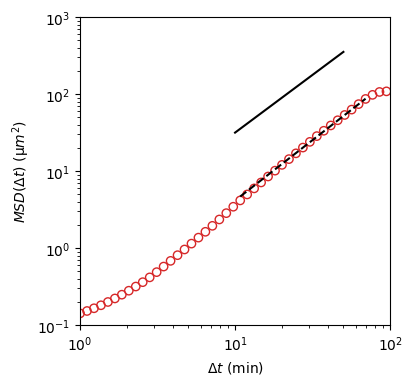

In [53]:

compare_x = np.linspace(10, 5e1)
tau = isf[0].tau/60

plt.figure(figsize=(4, 4))
plt.scatter(tau, single_cell_msd, facecolor="None", edgecolor="tab:red")
plt.plot(compare_x, compare_x ** 1.5, color="k")
plt.plot(fit_dt/60, result.eval(dt=fit_dt), ls="--", color="k")
plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 1e2)
plt.ylim(1e-1, 1e3)
plt.xlabel(r"$\Delta t$ (min)")
plt.ylabel(r"$MSD(\Delta t)$ (µ$m^2$)")

plt.show()


### putting all together

In [54]:
ignore_first = 25
ignore_last = 10
fit_dt = isf[0].tau[ignore_first:-ignore_last]

results = []
single_cell_msd_per_chunk = []


for i, _ in enumerate(chunks):
    print(f":: at chunk {i+1}/{len(chunks)}")
    # calculate msd 
    msd = msd_from_isf(isf[i])

    # interpolate msd in q for each dt so we can get the exact values at the crossing
    msd_at_crossing = []

    for i, dt in enumerate(tau):
        msd_inter_k = interp1d(k, msd[:, i])
        msd_at_crossing.append(msd_inter_k(np.array(crossings)))
    
    msd_at_crossing = np.array(msd_at_crossing)

    # extrapolate to single cell MSD
    single_cell_msd = []

    for i, dt in enumerate(tau):
        _inter_msd = interp1d(crossings, msd_at_crossing[i], fill_value="extrapolate")
        single_cell_msd.append(_inter_msd(0))
    single_cell_msd = np.array(single_cell_msd)

    single_cell_msd_per_chunk.append(single_cell_msd[:])

    # fit the single cell msd with the model
    result = msd_model.fit(
        single_cell_msd[ignore_first:-ignore_last], 
        dt=fit_dt
    )

    results.append(result.best_values)

print(results[-1])

:: at chunk 1/14
:: at chunk 2/14
:: at chunk 3/14


/tmp/ipykernel_2255190/4028674309.py:4: RuntimeWarning: invalid value encountered in log
  return (-4 * np.log(isf.data).T / isf.k**2).T


:: at chunk 4/14
:: at chunk 5/14
:: at chunk 6/14
:: at chunk 7/14
:: at chunk 8/14
:: at chunk 9/14
:: at chunk 10/14
:: at chunk 11/14
:: at chunk 12/14
:: at chunk 13/14
:: at chunk 14/14
{'x0_2': 0.7231332856893693, 'Deff': 0.0003085339128714448, 'beta': 1.3880646338216183}


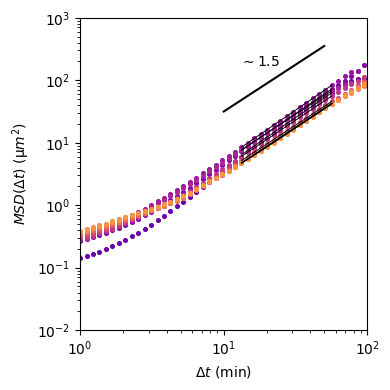

In [56]:
chunk_space = color_space(len(chunks))
compare_x = np.linspace(10, 5e1)
tau = isf[0].tau/60


plt.figure(figsize=(4, 4))
for i in range(len(chunks[:10])):
    plt.scatter(tau, single_cell_msd_per_chunk[i], s=7, color=chunk_space[i]) # facecolor="None", edgecolor=chunk_space[i])
    plt.plot(fit_dt/60, msd_model.eval(dt=fit_dt, **results[i]), ls="-", color="k", lw=0.7)


plt.plot(compare_x, compare_x ** 1.5, color="k")
plt.xscale('log')
plt.yscale('log')

plt.xlim(1, 1e2)
plt.ylim(1e-2, 1e3)
plt.xlabel(r"$\Delta t$ (min)")
plt.ylabel(r"$MSD(\Delta t)$ (µ$m^2$)")
plt.text(13, 170, r"$\sim 1.5$")
# plt.title("single cell MSD for the first 10 chunks")
plt.tight_layout()
plt.show()

In [57]:
beta_evo = [r['beta'] for r in results]
deff_evo = [r['Deff'] for r in results]

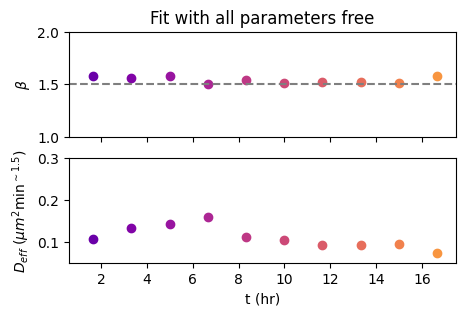

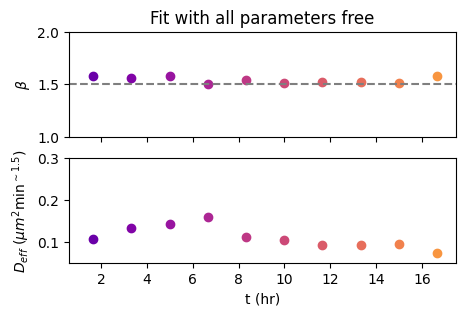

In [59]:

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 3))

ax = axes[0]
ax.set_title("Fit with all parameters free")
for i in range(len(chunks)):
    ax.scatter([chunk_age[i]], [beta_evo[i]], color=chunk_space[i])
ax.set_ylim(1, 2)
ax.axhline(1.5, ls="--", color="tab:grey")
ax.set_ylabel(r"$\beta$")

ax = axes[1]
for i in range(len(chunks)):
    # ax.scatter(chunk_age[i], deff_evo[i]*60**1.5, color=chunk_space[i])
    ax.scatter(chunk_age[i], deff_evo[i]*60**beta_evo[i], color=chunk_space[i])

ax.set(
    xlabel="t (hr)",
    ylabel=r"$D_{eff}\ (\mu m^2 \mathrm{min}^{\sim1.5})$",
    xlim=(None, 17.5),
    ylim=(0.05, 0.3)
)
plt.show()

### fixing the exponent to 1.5 

In [60]:
free_beta = np.array([r['beta'] for r in results])
free_deff = np.array([r['Deff'] for r in results])

msd_model = lm.Model(msd_fit)
msd_model.set_param_hint("beta", min=0, value=1.5, vary=False)
msd_model.set_param_hint("Deff", min=0, value=5e-4)
msd_model.set_param_hint("x0_2", min=0, value=1e-2)

ignore_first = 23
ignore_last = 8
fit_dt = isf[0].tau[ignore_first:-ignore_last]


In [61]:
ignore_first = 25
ignore_last = 10
fit_dt = isf[0].tau[ignore_first:-ignore_last]

results = []
single_cell_msd_per_chunk = []


for i, _ in enumerate(chunks):
    print(f":: at chunk {i+1}/{len(chunks)}")
    # calculate msd 
    msd = msd_from_isf(isf[i])

    # interpolate msd in q for each dt so we can get the exact values at the crossing
    msd_at_crossing = []

    for i, dt in enumerate(tau):
        msd_inter_k = interp1d(k, msd[:, i])
        msd_at_crossing.append(msd_inter_k(np.array(crossings)))
    
    msd_at_crossing = np.array(msd_at_crossing)

    # extrapolate to single cell MSD
    single_cell_msd = []

    for i, dt in enumerate(tau):
        _inter_msd = interp1d(crossings, msd_at_crossing[i], fill_value="extrapolate")
        single_cell_msd.append(_inter_msd(0))
    single_cell_msd = np.array(single_cell_msd)

    single_cell_msd_per_chunk.append(single_cell_msd[:])

    # fit the single cell msd with the model
    result = msd_model.fit(
        single_cell_msd[ignore_first:-ignore_last], 
        dt=fit_dt
    )

    results.append(result.best_values)

print(results[-1])

beta_evo_fixed = [r['beta'] for r in results]
deff_evo_fixed = [r['Deff'] for r in results]

:: at chunk 1/14
:: at chunk 2/14
:: at chunk 3/14
:: at chunk 4/14
:: at chunk 5/14
:: at chunk 6/14
:: at chunk 7/14
:: at chunk 8/14
:: at chunk 9/14
:: at chunk 10/14
:: at chunk 11/14
:: at chunk 12/14
:: at chunk 13/14
:: at chunk 14/14
{'x0_2': 1.473453132854997, 'Deff': 0.00012165055106883038, 'beta': 1.5}


/tmp/ipykernel_2255190/4028674309.py:4: RuntimeWarning: invalid value encountered in log
  return (-4 * np.log(isf.data).T / isf.k**2).T


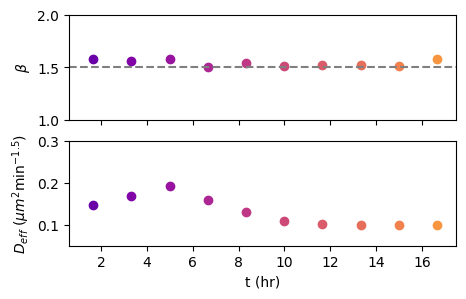

In [62]:
%matplotlib inline

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(5, 3))

ax = axes[0]
# ax.set_title(r"Free $\beta$ from before, $D_{eff}$ w/ fixed $\beta=1.5$")
for i in range(len(chunks)):
    ax.scatter([chunk_age[i]], free_beta[i], color=chunk_space[i])
ax.set_ylim(1, 2)
ax.axhline(1.5, ls="--", color="tab:grey")
ax.set_ylabel(r"$\beta$")

ax = axes[1]
for i in range(len(chunks)):
    # ax.scatter(chunk_age[i], deff_evo[i]*60**1.5, color=chunk_space[i])
    ax.scatter(chunk_age[i], deff_evo_fixed[i]*60**1.5, color=chunk_space[i])

ax.set(
    xlabel="t (hr)",
    ylabel=r"$D_{eff}\ (\mu m^2 \mathrm{min}^{-1.5})$",
    xlim=(None, 17.5),
    ylim=(0.05, 0.3)
)
plt.show()

In [63]:
# remove last row (last chunk usually has less statistics)

beta_deff_data = pd.DataFrame(data={
    "age": chunk_age,
    "beta_free": free_beta,
    "Deff_free": free_deff,
    "beta_fixed": beta_evo_fixed,
    "Deff_fixed_beta": deff_evo_fixed
}).iloc[:-1]

In [64]:
msd_df = pd.DataFrame(data={
    "lag": tau
})

for i, msdpc in enumerate(single_cell_msd_per_chunk):
    msd_df[f"chunk{i}"] = msdpc

single_cell_msd_per_chunk = msd_df

In [65]:
from matplotlib.offsetbox import AnchoredText


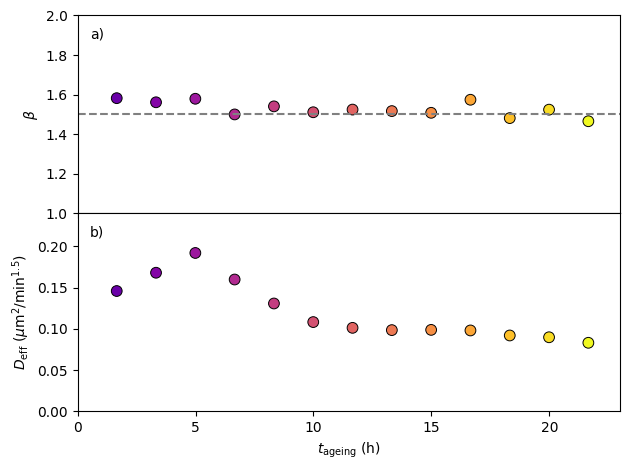

In [ ]:
fig = plt.figure(dpi=100)
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot beta
cspace = color_space(len(beta_deff_data))
axs[0].scatter(beta_deff_data['age'], beta_deff_data['beta_free'],  c=cspace, s=60, edgecolor='k', linewidth=0.7)
axs[0].axhline(1.5, c='gray', ls='--', )

axs[0].set_ylim(1, 2)

# plot Deff
axs[1].scatter(beta_deff_data['age'], beta_deff_data['Deff_fixed_beta'] * 60**beta_deff_data['beta_fixed'], c=cspace, s=60, edgecolor='k', linewidth=0.7)
axs[1].set_ylim(0, 0.24)
axs[1].set_xlim(0, 23)

axs[0].set_ylabel(r'$\beta$')
axs[1].set_ylabel(r'$D_{\text{eff}}$ ($\mu$m$^2$/min$^{1.5}$)')
axs[1].set_xlabel(r'$t_{\text{ageing}}$ (h)')

at = [
    AnchoredText("a)", prop=dict(size=10), frameon=False, loc='upper left'),
    AnchoredText("b)", prop=dict(size=10), frameon=False, loc='upper left'),
]
for _a, _at in zip(axs, at):
    _a.add_artist(_at)

fig.tight_layout()

fig.savefig('beta_Deff.pdf', dpi=600)

plt.show()

In [70]:
msd_fit_df = pd.DataFrame(columns=["chunk", "x0_2", "Deff", "beta"])

for i, res in enumerate(results):
    msd_fit_df = pd.concat([
        msd_fit_df,
        pd.DataFrame(
            data={"chunk": i} | res,
            index=[i]
        )]
    )

msd_fit_params_per_chunk = msd_fit_df.set_index('chunk')

/tmp/ipykernel_2255190/3788667086.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  msd_fit_df = pd.concat([


In [71]:
from matplotlib.lines import Line2D
import  matplotlib as mpl


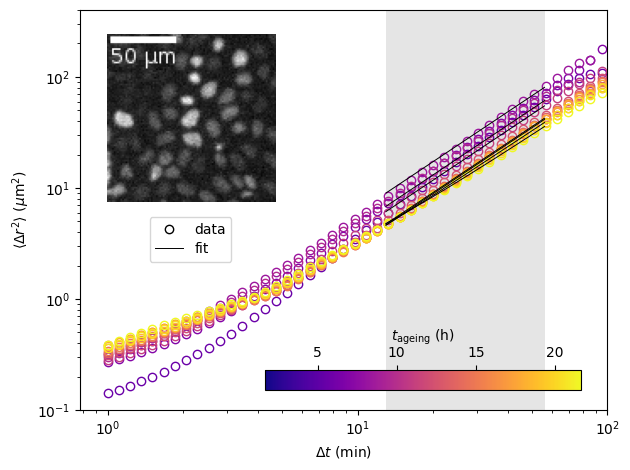

In [72]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define fit function
def fit_function(dt, x0_2, Deff, beta):
    D_eff = Deff * 60**beta
    return x0_2 + D_eff * dt**beta
dt = np.logspace(np.log10(13), np.log10(56), 100)

ax.fill_betweenx([1e-1, 4e2], [13, 13], [56, 56], color='gray', alpha=0.2, edgecolor=None)


for n, c in enumerate(cspace):
    ax.plot(single_cell_msd_per_chunk['lag'], single_cell_msd_per_chunk[f'chunk{n}'], 'o', color=c, markerfacecolor='none')
for n in range(len(cspace)):
    if n % 2 == 0:
        ax.plot(dt, fit_function(dt, *msd_fit_params_per_chunk.loc[n, ['x0_2', 'Deff', 'beta']]), color='k', linewidth=0.7)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\Delta t$ (min)')
ax.set_ylabel(r'$\langle \Delta r^2 \rangle$ ($\mu$m$^2$)')

ax.set_xlim(xmax=1e2)
ax.set_ylim(1e-1, 4e2)

axins = ax.inset_axes([0., 0.52, 0.42, 0.42])
img = plt.imread('mdck-1.5mio-last-frame-for-Henry-with-scalebar.png')
axins.imshow(img)
axins.set_axis_off()

# custom legend
custom_lines = [
    Line2D([0], [0], marker='o', markerfacecolor='none', linestyle='none', color='black', label='data'),
    Line2D([0], [0], linestyle='-', color='black', label='fit', linewidth=0.7),
]
ax.legend(handles=custom_lines, labelspacing=0.4, bbox_to_anchor=(0.3, 0.5))#, loc='center left')

cax = ax.inset_axes([0.35, 0.05, 0.6, 0.05])
norm = mpl.colors.Normalize(vmin=beta_deff_data['age'].min(),
                            vmax=beta_deff_data['age'].max())
cbar = cax.figure.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap='plasma'),
            cax=cax, pad=.05, orientation="horizontal",
            label=r'$t_{\text{ageing}}$ (h)')
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

fig.tight_layout()

fig.savefig('msd.pdf', dpi=600)

plt.show()